In [1]:
import pickle
from tqdm.auto import tqdm
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, brier_score_loss, accuracy_score, confusion_matrix

import torch
import torch.nn.functional as F
from torch.optim import Adam

import matplotlib.pyplot as plt

import INN

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')
batch_size = 256
n_epochs = 10

Using device: cuda


In [3]:
with open('../data/data_train.pt', 'rb') as file:
    X_train, y_train = pickle.load(file)

print(f'{X_train.shape = }')
print(f'{y_train.shape = }')

with open('../data/data_test.pt', 'rb') as file:
    X_test, y_test = pickle.load(file)

print(f'{X_test.shape = }')
print(f'{y_test.shape = }')

sc_X_train = StandardScaler()
X_train_scaled = torch.Tensor(sc_X_train.fit_transform(X_train)).to(device)
X_test_scaled = torch.Tensor(sc_X_train.transform(X_test)).to(device)

y_train = torch.Tensor(y_train).to(device)
y_test = torch.Tensor(y_test).to(device)

X_train.shape = (2521156, 28)
y_train.shape = (2521156, 2)
X_test.shape = (630290, 28)
y_test.shape = (630290, 2)


In [4]:
inn = INN.INN(X_train.shape[1], y_train.shape[1], n_blocks=10, coupling_network_layers=[128, 128, 128], device=device).to(device)

In [5]:
optimizer = Adam(inn.parameters(), lr=1e-4)

loss_history = {
    'x': [],
    'y': [],
    'z': [],
    'logdet': []
}

for i_epoch in range(n_epochs):

    inn.train()

    pbar = tqdm(range(int(np.ceil(len(X_train_scaled) / batch_size))), desc=f'Epoch {i_epoch}')

    for i in pbar:
        X = X_train_scaled[i * batch_size: (i+1) * batch_size]
        y = y_train[i * batch_size: (i+1) * batch_size]

        optimizer.zero_grad()
        loss = 0
        
        # --- FORWARD ---
        y_pred, z_pred = inn.forward(X)

        # y loss
        y_loss = F.binary_cross_entropy(y_pred, y) * 10
        loss += y_loss
        loss_history['y'].append(y_loss.detach().cpu().numpy())
        # z loss
        z_loss = torch.mean(torch.sum(z_pred**2, dim=-1)) / 2
        loss += z_loss
        loss_history['z'].append(z_loss.detach().cpu().numpy())
        # logdet loss
        logdet_loss = - torch.mean(inn.logdet_sum) / 10
        loss += logdet_loss
        loss_history['logdet'].append(logdet_loss.detach().cpu().numpy())
        

        # --- INVERSE ---
        X_pred = inn.inverse(y_pred, z_pred)
        # x loss
        x_loss = torch.clip(F.mse_loss(X_pred, X, reduction='mean'), None, 16)
        loss += x_loss
        loss_history['x'].append(x_loss.detach().cpu().numpy())


        loss.backward()
        optimizer.step()

        pbar.set_postfix({'batch_loss': loss.detach().cpu().numpy().round(2)})

Epoch 3:  96%|█████████▌| 9427/9849 [06:27<00:17, 24.34it/s, batch_loss=-1.73]


KeyboardInterrupt: 

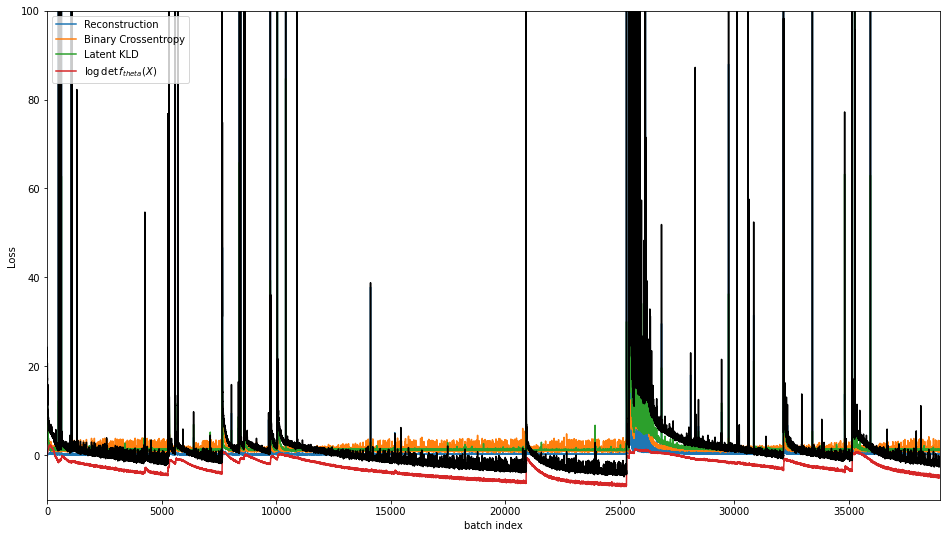

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))

ax.plot(loss_history['x'], label='Reconstruction')
ax.plot(loss_history['y'], label='Binary Crossentropy')
ax.plot(loss_history['z'], label='Latent KLD')
ax.plot(loss_history['logdet'], label=r'$\log \det f_{theta}(X)$')

ax.plot([sum([loss_history[k][i] for k in loss_history.keys()]) for i in range(len(loss_history['x']))], color='black', label='Total Loss')
ax.set_ylim(-10, 100); ax.set_xlim(0, len(loss_history['x']))
ax.set_xlabel('batch index'); ax.set_ylabel('Loss')
ax.legend();

In [17]:
inn.eval()

y_pred = np.empty((0, 2))
for i in tqdm(range(int(np.ceil(len(X_test_scaled) / batch_size)))):
    y_pred = np.concatenate([y_pred, inn.forward(X_test_scaled[i * batch_size: (i+1) * batch_size])[0].detach().cpu().numpy()], axis=0)

y_test = y_test.detach().cpu().numpy()

100%|██████████| 2463/2463 [00:23<00:00, 104.47it/s]


In [18]:
for i, y_label in enumerate(['hosp', 'death']):
    print(f'--- {y_label} ---')

    print(f'binary cross-entropy: {np.round(log_loss(y_test[:, i], y_pred[:, i]), 4)}')
    print(f'brier loss: {brier_score_loss(y_test[:, i], y_pred[:, i]).round(4)}')
    print(f'accuracy: {accuracy_score(y_test[:, i], y_pred[:, i] > 0.5).round(4)}')
    print('confusion matrix:')
    print(confusion_matrix(y_test[:, i], y_pred[:, i] > 0.5))
    print()

--- hosp ---
binary cross-entropy: 0.2178
brier loss: 0.0581
accuracy: 0.9308
confusion matrix:
[[584743    879]
 [ 42759   1909]]

--- death ---
binary cross-entropy: 0.0458
brier loss: 0.0111
accuracy: 0.9875
confusion matrix:
[[621343    143]
 [  7739   1065]]

